In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

# 1 Preparation

## 1.1 Embeddings

In [2]:
embeddings = pd.read_pickle('test/embeddings_complete.pickle')
len(embeddings)

10060

In [3]:
# combine 2 embeddings of father and mother for each individual
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    # combined_embedding = embeddings[i][1] + embeddings[i+1][1]    # sum embedding
    # combined_embedding = (embeddings[i][1] + embeddings[i+1][1])/2    # mean embedding
    combined_embedding = np.concatenate([embeddings[i][1], embeddings[i+1][1]]) # concatenate 2 embeddings.
    embedding.append(combined_embedding)
    # order of mother and father should in theory not matter # TODO: does it make sense?
    # embedding.append(np.concatenate([embeddings[i+1][1], embeddings[i][1]]))
    # sample_id.append(sid)
    # gene_id.append(gid)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})

In [4]:
df.head()

,sample_id,gene_id,embedding
0,NA20795,ENSG00000198502.5,"[0.017137265, -0.009090343, 0.0061443364, -0.0..."
1,HG00260,ENSG00000214425.1,"[0.05563126, 0.00049458974, -0.0046671517, -0...."
2,HG01632,ENSG00000176681.9,"[-0.051695395, 0.023533892, -0.04169209, 0.067..."
3,HG00173,ENSG00000238083.3,"[0.042141862, 0.0355676, 0.023393063, -0.03903..."
4,HG00178,ENSG00000229450.2,"[0.0736973, -0.022161566, -0.008337349, -0.040..."


## 1.2 Expression Data

In [5]:
expression = pd.read_csv("datasets/GD660.GeneQuantRPKM.txt.gz", sep="\t")
expression.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.9495,0.95837,0.51002,0.29422,0.2296,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000


In [6]:
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0]
expression.head()

,TargetID,Gene_Symbol,Chr,Coord,sample_id,expression
0,ENSG00000232629.4,ENSG00000232629.4,6,32731311,HG00096,9.96245
1,ENSG00000179344.11,ENSG00000179344.11,6,32636160,HG00096,43.78876
2,ENSG00000176681.9,ENSG00000176681.9,17,44370099,HG00096,6.34823
3,ENSG00000214425.1,ENSG00000214425.1,17,43595264,HG00096,0.40868
4,ENSG00000237541.3,ENSG00000237541.3,6,32709119,HG00096,51.03589


Prepare data for Expression prediction.

y = expression values for (sample, gene) pairs.

X = matrix containing the embeddings for each (sample, gene) pair.

In [7]:
df = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])
print(f"Number of samples for prediction expression: {len(df)}")

Number of samples for prediction expression: 4830


In [8]:
genes = df.gene_id.unique()
print(f"Number of genes: {len(genes)}")

Number of genes: 10


In [242]:
gene = genes[9]
y = df[df.gene_id==gene].expression.values
X = np.stack(df[df.gene_id==gene].embedding.values)

In [129]:
# y = df["expression"].values
# X = np.stack(df["embedding"].values)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 2 Prediction of Expression

## 2.1 Linear Regression

In [122]:
linear_regression_model = LinearRegression().fit(X_train, y_train)

In [12]:
predicted = linear_regression_model.predict(X_test)
print(f"R² of test set: {r2_score(y_test, predicted)}")
print(f"Explained variance score on test set: {explained_variance_score(y_test, predicted)}")
print(f"r value (Pearson correlation coefficient): {pearsonr(y_test, predicted)[0]}")

R² of test set: -3.7120729641048316
Explained variance score on test set: -3.7018043737715534
r value (Pearson correlation coefficient): 0.11493257512468484


## 2.2 Ridge Regression

In [260]:
ridge_regression_model = Ridge(alpha=0.05).fit(X_train, y_train)

In [261]:
predicted = ridge_regression_model.predict(X_test)
print(f"R² of test set: {r2_score(y_test, predicted)}")
print(f"Explained variance score on test set: {explained_variance_score(y_test, predicted)}")
print(f"r value (Pearson correlation coefficient): {pearsonr(y_test, predicted)[0]}")

R² of test set: 0.305709703368246
Explained variance score on test set: 0.31591228513668446
r value (Pearson correlation coefficient): 0.5621112610848746


Optimal alpha (wrt rvalue):


gene 1: 0.004 (0.73)<br>
gene 2: 0.01 (0.44)<br>
gene 3: 0.06 (0.67)<br>
gene 4: 1.0 (0.36)<br>
gene 5: 0.006 (0.74)<br>
gene 6: 0.02 (0.69)<br>
gene 7: 0.001 (0.52)<br>
gene 8: 0.0001 (0.71)<br>
gene 9: 0.0001 (0.36)<br>
gene 10:0.04 (0.56)

## 2.3 Lasso Regression

In [15]:
lasso_regression_model = Lasso(alpha=1.0).fit(X_train, y_train)

In [16]:
predicted = lasso_regression_model.predict(X_test)
print(f"R² of test set: {r2_score(y_test, predicted)}")
print(f"Explained variance score on test set: {explained_variance_score(y_test, predicted)}")
print(f"r value (Pearson correlation coefficient): {pearsonr(y_test, predicted)[0]}")

R² of test set: 0.14753052968192348
Explained variance score on test set: 0.15043780953195807
r value (Pearson correlation coefficient): 0.4289397350002451


## 2.4 Elastic Net Regression

In [17]:
elasticnet_regression_model = ElasticNet(random_state=53).fit(X_train, y_train)

In [18]:
predicted = elasticnet_regression_model.predict(X_test)
print(f"R² of test set: {r2_score(y_test, predicted)}")
print(f"Explained variance score on test set: {explained_variance_score(y_test, predicted)}")
print(f"r value (Pearson correlation coefficient): {pearsonr(y_test, predicted)[0]}")

R² of test set: 0.079975346817997
Explained variance score on test set: 0.08235313756905305
r value (Pearson correlation coefficient): 0.38174047720544557


## 2.5 Support Vector Machine

In [19]:
svr = make_pipeline(StandardScaler(), SVR(C=7500, epsilon=25)).fit(X_train, y_train)
# C: regularization parameter, epsilon: for epsilon-SVR model (no penalty during training when prediction is within true value +/- epsilon)
# uses default kernel: 'rbf'

In [20]:
predicted = svr.predict(X_test)
print(f"R² of test set: {r2_score(y_test, predicted)}")
print(f"Explained variance score on test set: {explained_variance_score(y_test, predicted)}")
print(f"r value (Pearson correlation coefficient): {pearsonr(y_test, predicted)[0]}")

R² of test set: 0.5625860812962608
Explained variance score on test set: 0.5643219033935669
r value (Pearson correlation coefficient): 0.7606243084697265


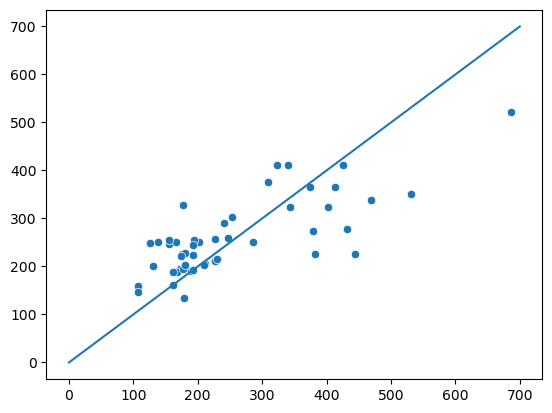

In [21]:
sns.scatterplot(x=y_test, y=predicted)
plt.plot([0, 700], [0, 700])

C       e       R
1.0     0.2     0.46
1.0     0.1     0.45
1.0     0.05    0.46
1.0     0.01    0.46
1.0     0.3     0.46
1.0     0.4     0.46
1.0     1.0     0.46
1.0     10      0.47
1.0     50      0.49

0.1     50      0.46
2.0     50      0.49
10.0    50      0.51
50.0    50      0.55
100.0   50      0.57
500.0   50      0.67
1000    50      0.70
5000    50      0.74
7500    50      0.74
10000   50      0.73

7500    10      0.76
7500    25      0.76

C should be around 7500, influence of epsilon is not that large.

# Comparison to prediction based on single SNPs

In [22]:
reference = pd.read_csv("datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz", sep="\t")
reference

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
0,rs1566523,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766663.0,21766621,42.0,-0.782786,3.883913e-78,77.410730
1,rs66732917,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766608.0,21766621,13.0,-0.775971,5.736684e-76,75.241339
2,rs12734589,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21760127.0,21766621,6494.0,-0.753190,3.094123e-69,68.509462
3,rs4654745,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21767096.0,21766621,475.0,-0.753071,3.339200e-69,68.476358
4,rs10916990,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21763132.0,21766621,3489.0,-0.750913,1.327049e-68,67.877113
...,...,...,...,...,...,...,...,...,...,...,...,...
419978,rs133379,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42468535.0,42466846,1689.0,0.231022,6.568113e-06,5.182559
419979,rs4253766,-,ENSG00000075234.12,ENSG00000075234.12,22,22,46623905.0,46663858,39953.0,-0.231008,6.576526e-06,5.182003
419980,rs73165152,-,ENSG00000100417.7,ENSG00000100417.7,22,22,42340397.0,41985894,354503.0,-0.231006,6.577641e-06,5.181930
419981,rs133352,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42434022.0,42466846,32824.0,0.231003,6.579434e-06,5.181811


In [21]:
print(reference[reference.GENE_ID==gene].rvalue.max())
print(reference[reference.GENE_ID==gene].rvalue.min())

0.287653816193465
-0.584827960561856
